In [115]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

from sklearn import ensemble
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels 
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor

Config parameters:

In [116]:
# Path to datasets
train_dataset_name = '../../data/processed/teco-psda-exercisesheet1-credit-2024/credit_train.csv'
test_dataset_name = '../../data/processed/teco-psda-exercisesheet1-credit-2024/credit_test.csv'

# Target directory for saving
target_dir = '../../data/predictions/teco-psda-exercisesheet1-credit-2024/'
name_of_predictions_file = 'credit_test.csv'

# Run hyperparameter optimization (with a given random state it is unnecessary to compute each time)
hyper_opt = True
save_predictions = True

## Load Data and make temporary train-test-split

In [117]:
df_train = pd.read_csv(train_dataset_name)
df_test = pd.read_csv(test_dataset_name)

print(df_train.columns)
print(df_test.columns)

Index(['Unnamed: 0', 'Income', 'Limit', 'Rating', 'Cards', 'Balance',
       'Student_Yes'],
      dtype='object')
Index(['Unnamed: 0', 'Income', 'Limit', 'Rating', 'Cards', 'Student_Yes'], dtype='object')


In [118]:
train = df_train.values.astype(float)
train_ids = train[:, 0]
train_balance = train[:, list(df_train.columns).index('Balance')]
train_data = train[:, [c != 'Balance' and c != 'Unnamed: 0' for c in df_train.columns]]

test = df_test.values.astype(float)
test_ids = test[:, 0]
test_data = test[:, [c != 'Unnamed: 0' for c in df_test.columns]]

print(train.shape)
print(train_ids.shape)
print(train_balance.shape)
print(train_data.shape)
print(test.shape)
print(test_ids.shape)
print(test_data.shape)

(350, 7)
(350,)
(350,)
(350, 5)
(50, 6)
(50,)
(50, 5)


In [119]:
np.mean(train_balance)

521.7085714285714

In [120]:
# temp_train_ids, temp_test_ids, temp_train_data, temp_test_data, temp_train_balance, temp_test_balance = model_selection.train_test_split(train_ids, train_data, train_balance, test_size=50, random_state=4)

# Shuffle data to use K-Fold cross-validation in the following 
indicis = np.arange(train_data.shape[0])
np.random.seed(6)
np.random.shuffle(indicis)
random_train_balance = train_balance[indicis]
random_train_data = train_data[indicis]

Findings: By only looking at a single validation dataset, the result on the test data is not as meaningful, which is why I use K-Fold cross-validation below. 

## Preprocess data

In [121]:
# This code was from the static validation set and therefore is commented out. 
# snv = preprocessing.StandardScaler()
# prep_temp_train_data = np.c_[snv.fit_transform(temp_train_data[:, :6]), temp_train_data[:, 6:]]
# prep_temp_test_data = np.c_[snv.transform(temp_test_data[:, :6]), temp_test_data[:, 6:]]

# Only apply scaler on numerical columns
snv = preprocessing.StandardScaler()
prep_train_data = np.c_[snv.fit_transform(random_train_data[:, :6]), random_train_data[:, 6:]]
prep_test_data = np.c_[snv.fit_transform(test_data[:, :6]), test_data[:, 6:]]

## Create regression models 
1) Logistic Regression
2) Gaussian Process
3) Support Vector Machine
4) Random Forest
5) AdaBoost
6) Gradient Boosting
7) Multi-layer Perceptron

In [122]:
regression_models = ['Logistic Regression', 'Gaussian Process', 'Support Vector Machine', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Multi-layer perceptron']
models_prediction_on_validation_worst = dict()

Logistic Regression: 
* Only to get a baseline performance, therefore no hyperparameter optimization has been made.

In [123]:
logistic_regression = linear_model.LogisticRegression()
scores = model_selection.cross_val_score(logistic_regression, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['Logistic Regression'] = - np.min(scores)

C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[208.91428571 163.02857143 135.98571429 184.97142857 182.11428571]
Mean: 175.00285714285715
Median: 182.11428571428573
Best: 135.9857142857143
Worst: 208.9142857142857


Gaussian Process:

In [124]:
gaussian_process = GaussianProcessRegressor(random_state=6)
scores = model_selection.cross_val_score(gaussian_process, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['Gaussian Process'] = - np.min(scores)

[ 998.71998062  401.55842885  500.92153629 1587.99438261 1554.27277823]
Mean: 1008.6934213198786
Median: 998.7199806167204
Best: 401.5584288503233
Worst: 1587.9943826065144


The result is quit bad, that is why I try to optimize the kernels.

In [125]:
kernel = kernels.ConstantKernel(constant_value_bounds=(1e-10, 1e10)) * kernels.RBF(length_scale_bounds=(1e-15, 1e10))
gaussian_process = GaussianProcessRegressor(kernel=kernel, random_state=6)
scores = model_selection.cross_val_score(gaussian_process, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.

[477.4        479.14285714 483.05714286 536.92857143 632.01428571]
Mean: 521.7085714285715
Median: 483.0571428571429
Best: 477.4
Worst: 632.0142857142857


C:\Users\Johannes\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Note: The error messages kept coming even after several adjustments on the bounds from the kernels, meanwhile, the error stays at a high level. This is why I tried out other kernels.

Note: GPR_With_Max_Iter is a helper class to adjust the maximum iteration from the optimizer in GaussianProcessRegressor in sklearn.

In [126]:
from scipy.optimize import minimize 
from sklearn.utils.optimize import _check_optimize_result

class GPR_With_Max_Iter(GaussianProcessRegressor):
    
    def __init__(self, kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None):
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer, n_restarts_optimizer=n_restarts_optimizer, normalize_y=normalize_y, copy_X_train=copy_X_train, n_targets=n_targets, random_state=random_state)
        self._max_iter = 1500000
        
    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                options = {'maxiter': self._max_iter},
            )
            _check_optimize_result("lbfgs", opt_res, max_iter=self._max_iter)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError(f"Unknown optimizer {self.optimizer}.")

        return theta_opt, func_min

In [127]:
kernel = kernels.DotProduct(sigma_0_bounds=(0.5, 1.5))
gaussian_process = GPR_With_Max_Iter(kernel=kernel, random_state=6)
scores = model_selection.cross_val_score(gaussian_process, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['Gaussian Process'] = - np.min(scores)

C:\Users\Johannes\AppData\Local\Temp\ipykernel_13620\2538685137.py:20: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res, max_iter=self._max_iter)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_13620\2538685137.py:20: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res, max_iter=self._max_iter)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_13620\2538685137.py:20: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

[76.94190325 80.92835432 80.73514186 81.87725612 78.61369324]
Mean: 79.81926975795201
Median: 80.73514186314173
Best: 76.94190325055804
Worst: 81.87725612095424


C:\Users\Johannes\AppData\Local\Temp\ipykernel_13620\2538685137.py:20: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res, max_iter=self._max_iter)


A better result, but the algorithm does not converge even with very high maximum iterations. 

Support Vector Machine:

In [128]:
svm_regressor = svm.SVR()
scores = model_selection.cross_val_score(svm_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[363.65139007 354.51010276 314.64842005 382.67514867 419.04892376]
Mean: 366.90679706144766
Median: 363.65139006638145
Best: 314.648420050705
Worst: 419.0489237606252


Note: The result without hyperparameter optimization is not good. In the following Bayesian optimization is used to find the optimal hyperparameter. The parameter bounds are:
* 'C': (0.00001, 2)
    - I look in the size one range around the default value. The value zero is not possible. 
* 'gamma': (0, 1.5)
    - This values has to be non-negative, I choose for the lower bound therefore zero. I also try to explore the search area for gamma greater than one that is why choose the limit 1.5 
* 'epsilon': (0, 0.5)
    - The default value is 0.1 and the value has to be non-negative. To explore the neighbourhood of the default value, I choose the search area from zero to 0.5

In [165]:
def hyperparameter_function_svr(gamma, C, epsilon):
    """ Function for hyperparameter optimization
    """
    svm_regressor = svm.SVR(gamma=gamma, C=C, epsilon=epsilon)
    scores = model_selection.cross_val_score(svm_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
    return np.min(scores)

# Bounded region of parameter space
pbounds = {'gamma': (0, 1.5), 'C': (0.00001, 2), 'epsilon': (0, 0.5)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_svr,
    pbounds=pbounds,
    random_state=6,
)

if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | -423.9    | 1.786     | 0.166     | 1.232     |
| 2         | -443.6    | 0.0834    | 0.05383   | 0.8926    |
| 3         | -423.1    | 1.06      | 0.2094    | 0.5031    |
| 4         | -428.8    | 1.245     | 0.2191    | 1.104     |
| 5         | -430.0    | 1.036     | 0.2894    | 0.968     |
| 6         | -409.2    | 1.98      | 0.4099    | 0.6198    |
| 7         | -407.1    | 1.753     | 0.4119    | 0.08171   |
| 8         | -426.5    | 1.437     | 0.4011    | 1.105     |
| 9         | -410.7    | 1.418     | 0.2705    | 0.1872    |
| 10        | -402.5    | 1.915     | 0.2016    | 0.3254    |
| 11        | -413.4    | 1.435     | 0.4971    | 0.3834    |
| 12        | -427.3    | 1.343     | 0.2995    | 1.076     |
| 13        | -405.1    | 1.875     | 0.1759    | 0.3805    |
| 14        | -434.3    | 0.805     | 0.3733    | 1.086     |
| 15    

In [164]:
# optimal hyperparameter
gamma = 0.16276605047705478
C = 2.0
epsilon = 0.0

svm_regressor = svm.SVR(gamma=gamma, C=C, epsilon=epsilon)
scores = model_selection.cross_val_score(svm_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['SVM'] = - np.min(scores)

[343.238696   333.61214369 296.45128723 364.14001604 397.93745313]
Mean: 347.07591921805835
Median: 343.23869599894374
Best: 296.4512872322782
Worst: 397.9374531296389


Note: After hyperparameter optimization is the result still not good.

Random Forest:

In [131]:
random_forest = ensemble.RandomForestRegressor(n_estimators=100, random_state=6)
scores = model_selection.cross_val_score(random_forest, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[57.61228571 47.76142857 70.67128571 84.062      67.76428571]
Mean: 65.57425714285714
Median: 67.7642857142857
Best: 47.761428571428574
Worst: 84.06199999999998


Note: In the following Bayesian optimization is used to find the optimal hyperparameter. The parameter bounds are:
* 'n_estimators': (10, 350)
    - As I prefer not to set a limit on the number of trees, I choose to set the maximum very high.
* 'min_split' equals 'min_samples_split': (2, 5)
    - The default value is one and, it has to be greater equal two (for integer values). I want to explore the neighbourhood of the default value that is why I choose 5 as an upper bound.
* 'min_leaf' equals 'min_samples_leaf': (1, 5)
    - The default value is one and, it has to be greater equal one (for integer values). I want to explore neighbourhood of the default value that is why I choose 5 as an upper bound.

In [132]:
def hyperparameter_function_random_forest(n_estimators, min_split, min_leaf):
    """ Function for hyperparameter optimization
    """    
    random_forest = ensemble.RandomForestRegressor(n_estimators=int(n_estimators), min_samples_split=int(min_split), min_samples_leaf=int(min_leaf), random_state=6)
    scores = model_selection.cross_val_score(random_forest, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
    return np.min(scores)


# Bounded region of parameter space
pbounds = {'n_estimators': (10, 350), 'min_split': (2, 5), 'min_leaf': (1, 5)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_random_forest,
    pbounds=pbounds,
    random_state=6,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   | min_leaf  | min_split | n_esti... |
-------------------------------------------------------------
| 1         | -98.36    | 4.571     | 2.996     | 289.2     |
| 2         | -85.87    | 1.167     | 2.323     | 212.3     |
| 3         | -92.49    | 3.119     | 3.256     | 124.0     |
| 4         | -93.46    | 3.49      | 3.314     | 260.2     |
| 5         | -92.85    | 3.072     | 3.737     | 229.4     |
| 6         | -97.73    | 4.961     | 4.46      | 150.5     |
| 7         | -97.86    | 4.505     | 4.471     | 28.52     |
| 8         | -93.46    | 3.875     | 4.407     | 260.4     |
| 9         | -92.08    | 3.837     | 3.623     | 52.44     |
| 10        | -96.14    | 4.831     | 3.21      | 83.76     |
| 11        | -91.73    | 3.869     | 4.983     | 96.91     |
| 12        | -93.54    | 3.685     | 3.797     | 253.9     |
| 13        | -97.12    | 4.749     | 3.055     | 96.24     |
| 14        | -89.14    | 2.61      | 4.24      | 256.2     |
| 15    

Note: I run it a second time with different randomstate to maybe improve the first result.

In [133]:
optimizer = BayesianOptimization(
    f=hyperparameter_function_random_forest,
    pbounds=pbounds,
    random_state=10,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   | min_leaf  | min_split | n_esti... |
-------------------------------------------------------------
| 1         | -97.38    | 4.085     | 2.062     | 225.4     |
| 2         | -91.48    | 3.995     | 3.496     | 86.43     |
| 3         | -86.55    | 1.792     | 4.282     | 67.5      |
| 4         | -85.96    | 1.353     | 4.056     | 334.2     |
| 5         | -85.91    | 1.016     | 3.537     | 286.3     |
| 6         | -91.84    | 3.45      | 4.165     | 109.2     |
| 7         | -97.54    | 4.671     | 4.144     | 194.5     |
| 8         | -85.24    | 1.569     | 3.12      | 239.2     |
| 9         | -89.17    | 2.767     | 3.302     | 220.0     |
| 10        | -92.93    | 3.053     | 3.951     | 214.4     |
| 11        | -98.47    | 4.221     | 3.565     | 318.9     |
| 12        | -88.05    | 2.277     | 2.271     | 112.2     |
| 13        | -89.18    | 1.456     | 4.486     | 25.94     |
| 14        | -93.75    | 3.505     | 3.643     | 288.6     |
| 15    

Note: Now the optimal parameters are selected from the search (+ made to integer because they are not float values)

In [134]:
# optimal hyperparameter
n_estimators = 98
min_samples_split = 2
min_samples_leaf = 1
 
random_forest = ensemble.RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
scores = model_selection.cross_val_score(random_forest, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['Random Forest'] = - np.min(scores)

[57.47259475 47.74169096 70.31953353 84.01005831 67.87215743]
Mean: 65.48320699708454
Median: 67.87215743440231
Best: 47.74169096209913
Worst: 84.0100583090379


AdaBoost:

In [135]:
adaboost = ensemble.AdaBoostRegressor()
scores = model_selection.cross_val_score(adaboost, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['AdaBoost'] = - np.min(scores)

[123.9757575  124.60085897 116.06715833 142.56342034 133.66461943]
Mean: 128.1743629167708
Median: 124.6008589720202
Best: 116.06715833444447
Worst: 142.56342034220626


Note: The initial performance from default AdaBoost is compared to Random Forest bad, that is why it has not been further investigated.

GradientBoosting:

In [136]:
gradient_boosting = ensemble.GradientBoostingRegressor()
scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[54.62697873 50.77288464 76.39305263 80.67024192 62.72511688]
Mean: 65.03765496054194
Median: 62.72511688195557
Best: 50.77288463709764
Worst: 80.67024192495563


Note: In the following Bayesian optimization is used to find the optimal hyperparameter. The parameter bounds are:
* 'lr': (0.1, 0.5)
    - I want to explore the neighbourhood of the default value that is why I choose 0.5 as an upper bound.
* 'subsample': (0.001, 1.0)
    - The default value is one and the value has to be in the range (0.0, 1.0]. I want to explore nearly the full range.
* 'n_estimators': (10, 500)
    - As I prefer not to set a limit on the number of trees, I choose to set the maximum very high.
* 'min_split' equals 'min_samples_split': (2, 20)
    - The default value is one and, it has to be greater equal two (for integer values). I want to explore the neighbourhood of the default value that is why I choose 20 as an upper bound.
* 'min_leaf' equals 'min_samples_leaf': (1, 20)
    - The default value is one and, it has to be greater equal one (for integer values). I want to explore neighbourhood of the default value that is why I choose 20 as an upper bound.

In [137]:
def hyperparameter_function_gradient_boost(lr, subsample, n_estimators, min_split, min_leaf):
    """ Function for hyperparameter optimization
    """    
    gradient_boosting = ensemble.GradientBoostingRegressor(learning_rate=lr, n_estimators=int(n_estimators), subsample=subsample, min_samples_split=int(min_split), min_samples_leaf=int(min_leaf), random_state=6)
    scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
    return np.min(scores)


# Bounded region of parameter space
pbounds = {'lr': (0.1, 0.5), 'subsample': (0.001, 1.0) ,'n_estimators': (10, 500), 'min_split': (2, 20), 'min_leaf': (1, 20)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost,
    pbounds=pbounds,
    random_state=7,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -93.94    | 0.1305    | 15.82     | 9.891     | 364.5     | 0.978     |
| 2         | -91.28    | 0.3154    | 10.52     | 3.297     | 141.5     | 0.5004    |
| 3         | -179.3    | 0.3717    | 16.27     | 8.857     | 42.31     | 0.2889    |
| 4         | -427.6    | 0.4638    | 5.054     | 10.14     | 466.3     | 0.02587   |
| 5         | -98.95    | 0.3402    | 19.05     | 6.145     | 278.8     | 0.9092    |
| 6         | -87.98    | 0.1533    | 10.94     | 15.51     | 337.8     | 0.4683    |
| 7         | -86.47    | 0.1819    | 10.32     | 8.703     | 243.9     | 0.3665    |
| 8         | -167.5    | 0.4352    | 15.6      | 7.652     | 290.6     | 0.2768    |
| 9         | -68.22    | 0.2811    | 7.707     | 13.83     | 191.5     | 0.4596    |
| 10        | -73.06    | 0.3877    | 8.847     | 18.3

Note: I run it several times with different randomstate to maybe improve the earlier result.

In [138]:
optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost,
    pbounds=pbounds,
    random_state=4,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -85.18    | 0.4868    | 11.4      | 19.51     | 360.3     | 0.698     |
| 2         | -160.0    | 0.1864    | 19.55     | 2.112     | 134.0     | 0.4354    |
| 3         | -105.6    | 0.4118    | 4.756     | 17.53     | 491.9     | 0.1647    |
| 4         | -77.97    | 0.3389    | 1.171     | 8.958     | 31.64     | 0.9567    |
| 5         | -199.8    | 0.2745    | 19.03     | 16.15     | 434.5     | 0.174     |
| 6         | -94.33    | 0.13      | 12.41     | 5.023     | 369.4     | 0.409     |
| 7         | -198.2    | 0.3112    | 18.81     | 11.39     | 63.01     | 0.1591    |
| 8         | -89.78    | 0.3181    | 10.96     | 13.48     | 206.7     | 0.6502    |
| 9         | -102.6    | 0.2588    | 12.85     | 15.81     | 97.7      | 0.3762    |
| 10        | -94.72    | 0.301     | 14.05     | 6.56

In [139]:
optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost,
    pbounds=pbounds,
    random_state=10,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -67.63    | 0.4085    | 1.394     | 13.41     | 376.9     | 0.499     |
| 2         | -104.2    | 0.1899    | 4.763     | 15.69     | 92.86     | 0.08925   |
| 3         | -92.16    | 0.3741    | 19.11     | 2.071     | 261.0     | 0.8128    |
| 4         | -103.8    | 0.345     | 14.71     | 7.254     | 459.7     | 0.7149    |
| 5         | -69.07    | 0.317     | 3.701     | 8.72      | 340.3     | 0.4424    |
| 6         | -93.09    | 0.2736    | 12.74     | 11.24     | 328.7     | 0.6014    |
| 7         | -215.3    | 0.4221    | 10.91     | 18.36     | 166.4     | 0.09137   |
| 8         | -81.02    | 0.2203    | 3.166     | 16.92     | 32.98     | 0.6267    |
| 9         | -156.2    | 0.319     | 16.57     | 5.581     | 429.9     | 0.3523    |
| 10        | -101.4    | 0.4019    | 6.623     | 17.9

Note: I run it with changed bounds which restrict the search area for some parameters. (I ensure that the best parameters from previous runs are still in the search area)

In [140]:
# Bounded region of parameter space
pbounds = {'lr': (0.1, 0.2), 'subsample': (0.5, 1.0) ,'n_estimators': (10, 500), 'min_split': (2, 20), 'min_leaf': (1, 5)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost,
    pbounds=pbounds,
    random_state=6,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -83.59    | 0.1893    | 2.328     | 16.78     | 30.43     | 0.5538    |
| 2         | -66.13    | 0.1595    | 3.119     | 9.539     | 174.3     | 0.8113    |
| 3         | -66.73    | 0.1438    | 3.944     | 11.32     | 293.6     | 0.8227    |
| 4         | -70.64    | 0.199     | 4.279     | 9.438     | 439.4     | 0.9119    |
| 5         | -66.73    | 0.1054    | 3.875     | 16.44     | 370.8     | 0.8546    |
| 6         | -65.21    | 0.1541    | 1.499     | 19.24     | 207.6     | 0.6085    |
| 7         | -66.54    | 0.1717    | 4.977     | 6.601     | 338.9     | 0.7995    |
| 8         | -65.29    | 0.1717    | 4.749     | 8.333     | 134.3     | 0.7012    |
| 9         | -63.4     | 0.1747    | 3.896     | 9.31      | 494.8     | 0.7252    |
| 10        | -70.16    | 0.1374    | 3.839     | 3.48

In [141]:
# optimal hyperparameter
lr = 0.12411271668396577
n_estimators = 256
min_samples_split = 3
min_samples_leaf = 1
subsample = 0.502158565890093

gradient_boosting = ensemble.GradientBoostingRegressor(learning_rate=lr, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[38.43938104 43.51295692 52.34326719 53.64387073 42.2131648 ]
Mean: 46.03052813458327
Median: 43.512956918029104
Best: 38.439381037072685
Worst: 53.643870727767805


Note: By looking at the prediction of the balance from the test set I noticed that some predictions are negative. In the train set all balances are positive.
* Assumption: Balance must be positive
$\Rightarrow$ Set every negative predicted value to zero

In [142]:
class GradientBoostingRegressorWithCutoff():
    
    def __init__(self, learning_rate, n_estimators, subsample, min_samples_split, min_samples_leaf, random_state, loss=None, criterion=None, min_weight_fraction_leaf=None, max_depth=None, min_impurity_decrease=None, init=None, max_features=None, alpha=None, verbose=None, max_leaf_nodes=None, warm_start=None, n_iter_no_change=None, tol=None, ccp_alpha=None, validation_fraction=None):
        self.gradient_boosting = ensemble.GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
    
    def fit(self, X, y):
        self.gradient_boosting.fit(X, y)
    
    def predict(self, X):
        prediction = self.gradient_boosting.predict(X)
        prediction = prediction * np.array(prediction > 0, dtype=int)
        return prediction
    
    def get_params(self, deep=True):
        return self.gradient_boosting.get_params(deep=deep)

def hyperparameter_function_gradient_boost_with_cut(lr, subsample, n_estimators, min_split, min_leaf):
    """ Function for hyperparameter optimization
    """    
    gradient_boosting = GradientBoostingRegressorWithCutoff(learning_rate=lr, n_estimators=int(n_estimators), subsample=subsample, min_samples_split=int(min_split), min_samples_leaf=int(min_leaf), random_state=6)
    scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
    return np.min(scores)


# Bounded region of parameter space
pbounds = {'lr': (0.1, 0.5), 'subsample': (0.001, 1.0) ,'n_estimators': (10, 500), 'min_split': (2, 20), 'min_leaf': (1, 20)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost_with_cut,
    pbounds=pbounds,
    random_state=7,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -92.07    | 0.1305    | 15.82     | 9.891     | 364.5     | 0.978     |
| 2         | -86.78    | 0.3154    | 10.52     | 3.297     | 141.5     | 0.5004    |
| 3         | -178.4    | 0.3717    | 16.27     | 8.857     | 42.31     | 0.2889    |
| 4         | -427.6    | 0.4638    | 5.054     | 10.14     | 466.3     | 0.02587   |
| 5         | -94.81    | 0.3402    | 19.05     | 6.145     | 278.8     | 0.9092    |
| 6         | -85.46    | 0.1533    | 10.94     | 15.51     | 337.8     | 0.4683    |
| 7         | -81.55    | 0.1819    | 10.32     | 8.703     | 243.9     | 0.3665    |
| 8         | -166.1    | 0.4352    | 15.6      | 7.652     | 290.6     | 0.2768    |
| 9         | -62.55    | 0.2811    | 7.707     | 13.83     | 191.5     | 0.4596    |
| 10        | -68.24    | 0.3877    | 8.847     | 18.3

Note: I run it with changed bounds which restrict the search area for some parameters. I allow for 'min_split' higher bounds to explore if the earlier bounds where to conservative. (I ensure that the best parameters from previous runs are still in the search area)

In [143]:
# Bounded region of parameter space
pbounds = {'lr': (0.1, 0.2), 'subsample': (0.3, 1.0) ,'n_estimators': (10, 500), 'min_split': (2, 25), 'min_leaf': (1, 5)}


optimizer = BayesianOptimization(
    f=hyperparameter_function_gradient_boost_with_cut,
    pbounds=pbounds,
    random_state=10,
)
if hyper_opt:
    optimizer.maximize(
        init_points=50,
        n_iter=100,
    )

|   iter    |  target   |    lr     | min_leaf  | min_split | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -60.27    | 0.1771    | 1.083     | 16.57     | 376.9     | 0.649     |
| 2         | -70.75    | 0.1225    | 1.792     | 19.49     | 92.86     | 0.3618    |
| 3         | -61.63    | 0.1685    | 4.814     | 2.091     | 261.0     | 0.8688    |
| 4         | -64.65    | 0.1613    | 3.887     | 8.713     | 459.7     | 0.8002    |
| 5         | -62.55    | 0.1543    | 1.569     | 10.59     | 340.3     | 0.6093    |
| 6         | -65.12    | 0.1434    | 3.471     | 13.8      | 328.7     | 0.7207    |
| 7         | -60.24    | 0.1805    | 3.087     | 22.9      | 166.4     | 0.3633    |
| 8         | -105.6    | 0.1301    | 1.456     | 21.06     | 32.98     | 0.7384    |
| 9         | -57.1     | 0.1548    | 4.277     | 6.576     | 429.9     | 0.5462    |
| 10        | -65.67    | 0.1755    | 2.184     | 22.3

In [144]:
optimizer.max

{'target': -50.53606588340304,
 'params': {'lr': 0.14144046607352362,
  'min_leaf': 1.0153621845647702,
  'min_split': 10.740149872547972,
  'n_estimators': 413.348152871206,
  'subsample': 0.37188453422220363}}

In [145]:
# optimal hyperparameter
lr = 0.14144046607352362
n_estimators = 413
min_samples_split = 10
min_samples_leaf = 1
subsample = 0.37188453422220363

gradient_boosting = GradientBoostingRegressorWithCutoff(learning_rate=lr, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['Gradient Boosting'] = - np.min(scores)

[39.15104272 41.98859793 41.35442102 50.53606588 45.26007702]
Mean: 43.65804091449502
Median: 41.98859793398807
Best: 39.15104271535567
Worst: 50.53606588340304


MLP Regressor:

In [146]:
mlp_regressor = MLPRegressor(learning_rate='constant', max_iter=15000, random_state=7)
scores = model_selection.cross_val_score(mlp_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[15.54998731 15.80081728 14.58998858 13.98101353 16.43006684]
Mean: 15.270374706587194
Median: 15.549987312631746
Best: 13.981013525440371
Worst: 16.430066839940093


For further evaluation look at the 240426_Johannes_credit_mlp notebook. This is a separate notebook because the computations have been done on the SCC cluster.

{'target': -14.624831632476509,
 'params': {'alpha': 0.058428237542730146,
  'batch_size': 158.60572041092112,
  'beta_1': 0.9355582054882612,
  'beta_2': 0.9089543612935872,
  'hidden_size': 126.6933372337246,
  'learning_rate_init': 0.001283462649989831}}

In [147]:
class MLPWithCutoff():
    
    def __init__(self, learning_rate_init, batch_size, alpha, beta_1, beta_2, hidden_layer_sizes=None, activation='relu', *, solver='adam', learning_rate='constant', power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, epsilon=1e-08, n_iter_no_change=10, max_fun=15000):
        self.mlp_regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', alpha=alpha, batch_size=int(batch_size), learning_rate='constant', learning_rate_init=learning_rate_init, power_t=0.5, max_iter=5000, shuffle=True, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=beta_1, beta_2=beta_2, epsilon=1e-08, n_iter_no_change=10, max_fun=15000, random_state=7)
        
    def fit(self, X, y):
        self.mlp_regressor.fit(X, y)
    
    def predict(self, X):
        prediction = self.mlp_regressor.predict(X)
        prediction = prediction * np.array(prediction > 0, dtype=int)
        return prediction
    
    def get_params(self, deep=True):
        return self.mlp_regressor.get_params(deep=deep)

In [148]:
# optimal hyperparameter
alpha = 0.058428237542730146
batch_size = 158.60572041092112
beta_1 = 0.9355582054882612
beta_2 = 0.9089543612935872
hidden_size = 126.6933372337246
learning_rate_init = 0.001283462649989831

hidden_layer_sizes = [int(hidden_size)] * 1
mlp_regressor = MLPWithCutoff(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, batch_size=int(batch_size), learning_rate_init=learning_rate_init, beta_1=beta_1, beta_2=beta_2, max_iter=15000, random_state=7)
scores = model_selection.cross_val_score(mlp_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

models_prediction_on_validation_worst['MLP'] = - np.min(scores)

[12.27809476 14.53232656 13.47522207 12.37646864 14.32671329]
Mean: 13.397765062903536
Median: 13.475222071245938
Best: 12.278094756859746
Worst: 14.5323265587687


## Compare the regression models

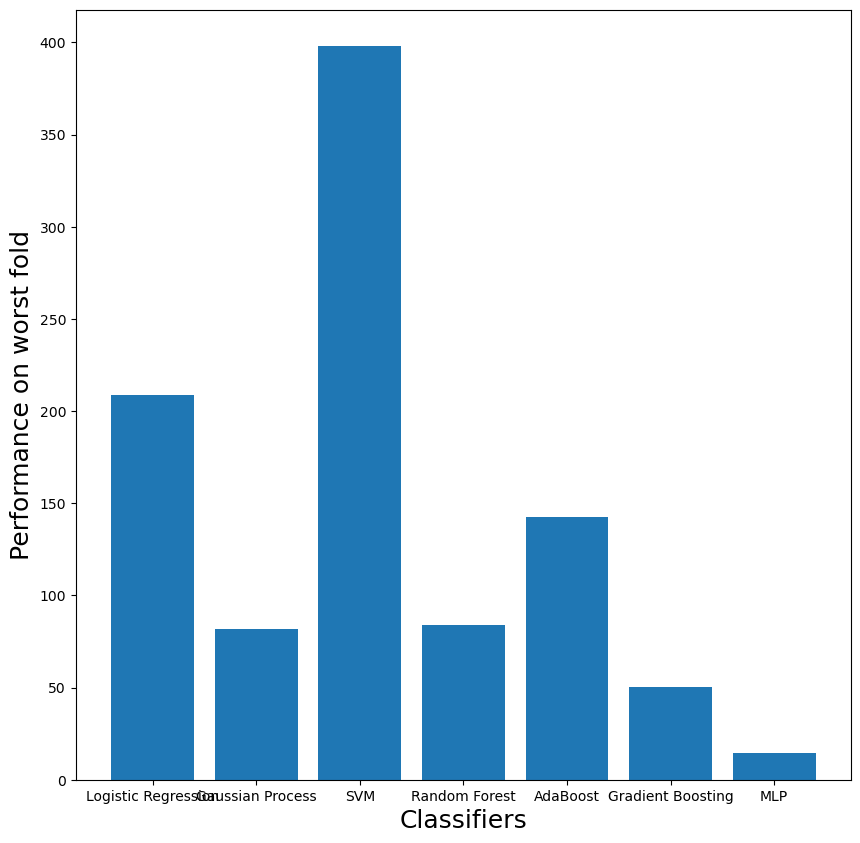

In [149]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Classifiers', fontsize=18)
ax.set_ylabel('Performance on worst fold', fontsize=18)
ax.set_title('', fontsize=20)
plt.bar(models_prediction_on_validation_worst.keys(), models_prediction_on_validation_worst.values())
plt.show()

## Make prediction on real test set

Hereafter, the best two classifiers Gradient Boosting and Multi-layer Perceptron are trained on the complete train dataset. Afterwards, the prediction on the test data is carried out and saved.

Gradient Boosting:

In [150]:
# optimal hyperparameter
lr = 0.1
n_estimators = 231
min_samples_split = 0.0344742932254589
min_samples_leaf = 0.001
subsample = 0.3738150348136798

gradient_boosting = ensemble.GradientBoostingRegressor(learning_rate=lr, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
gradient_boosting.fit(prep_train_data, random_train_balance)
train_balance_pred = gradient_boosting.predict(prep_train_data)
model_prediction_on_train = metrics.mean_absolute_error(train_balance_pred, train_balance_pred)
print(model_prediction_on_train)

0.0


In [151]:
scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=train_balance, cv=10, scoring='neg_mean_absolute_error')
print(scores)
print(np.mean(scores))
print(np.median(scores))
print(np.max(scores))
print(np.min(scores))

[-392.49577553 -501.17259206 -475.46563522 -508.81564707 -453.67181628
 -422.70245213 -468.73416122 -383.98342251 -329.71551394 -499.50565404]
-443.6262669997942
-461.20298874966164
-329.71551393576385
-508.8156470746016


In [152]:
gradient_boosting

GradientBoostingRegressor(min_samples_leaf=0.001,
                          min_samples_split=0.0344742932254589,
                          n_estimators=231, random_state=6,
                          subsample=0.3738150348136798)

In [153]:
test_balance_pred = gradient_boosting.predict(prep_test_data)
print(test_balance_pred.shape)

# Create pandas data frame + Save predictions
time_str = time.strftime("%Y%m%d-%H%M%S")
df_test_pred = pd.DataFrame({'Id': test_ids.astype(int), 'Expected': test_balance_pred})
df_test_pred.to_csv(target_dir + time_str + '_GB_' + name_of_predictions_file, index=False)

(50,)


Gradient Boosting with Cutoff:

In [154]:
# optimal hyperparameter
lr = 0.14144046607352362
n_estimators = 413
min_samples_split = 10
min_samples_leaf = 1
subsample = 0.37188453422220363

gradient_boosting = GradientBoostingRegressorWithCutoff(learning_rate=lr, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=6)
scores = model_selection.cross_val_score(gradient_boosting, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[39.15104272 41.98859793 41.35442102 50.53606588 45.26007702]
Mean: 43.65804091449502
Median: 41.98859793398807
Best: 39.15104271535567
Worst: 50.53606588340304


In [155]:
gradient_boosting.fit(prep_train_data, random_train_balance)
train_balance_pred = gradient_boosting.predict(prep_train_data)
model_prediction_on_train = metrics.mean_absolute_error(train_balance_pred, train_balance_pred)
print(model_prediction_on_train)

0.0


In [156]:
gradient_boosting.gradient_boosting

GradientBoostingRegressor(learning_rate=0.14144046607352362,
                          min_samples_split=10, n_estimators=413,
                          random_state=6, subsample=0.37188453422220363)

In [157]:
test_balance_pred = gradient_boosting.predict(prep_test_data)
print(test_balance_pred.shape)

# Create pandas data frame + Save predictions
time_str = time.strftime("%Y%m%d-%H%M%S")
df_test_pred = pd.DataFrame({'Id': test_ids.astype(int), 'Expected': test_balance_pred})
df_test_pred.to_csv(target_dir + time_str + '_GBWC_' + name_of_predictions_file, index=False)

(50,)


MLP Regressor:

In [158]:
# optimal hyperparameter
alpha = 0.058428237542730146
batch_size = 158.60572041092112
beta_1 = 0.9355582054882612
beta_2 = 0.9089543612935872
hidden_size = 126.6933372337246
learning_rate_init = 0.001283462649989831

hidden_layer_sizes = [int(hidden_size)] * 1
mlp_regressor = MLPWithCutoff(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, batch_size=int(batch_size), learning_rate_init=learning_rate_init, beta_1=beta_1, beta_2=beta_2, max_iter=15000, random_state=7)
scores = model_selection.cross_val_score(mlp_regressor, X=prep_train_data, y=random_train_balance, cv=5, scoring='neg_mean_absolute_error')
print(- scores)
print('Mean: ' + str(- np.mean(scores)))
print('Median: ' + str(- np.median(scores)))
print('Best: ' + str(- np.max(scores)))
print('Worst: ' + str(- np.min(scores)))

[12.27809476 14.53232656 13.47522207 12.37646864 14.32671329]
Mean: 13.397765062903536
Median: 13.475222071245938
Best: 12.278094756859746
Worst: 14.5323265587687


In [159]:
mlp_regressor.fit(prep_train_data, random_train_balance)
train_balance_pred = mlp_regressor.predict(prep_train_data)
model_prediction_on_train = metrics.mean_absolute_error(train_balance_pred, train_balance_pred)
print(model_prediction_on_train)

0.0


In [160]:
mlp_regressor.mlp_regressor

MLPRegressor(alpha=0.058428237542730146, batch_size=158,
             beta_1=0.9355582054882612, beta_2=0.9089543612935872,
             hidden_layer_sizes=[126], learning_rate_init=0.001283462649989831,
             max_iter=5000, random_state=7)

In [161]:
test_balance_pred = mlp_regressor.predict(prep_test_data)
print(test_balance_pred.shape)

# Create pandas data frame + Save predictions
time_str = time.strftime("%Y%m%d-%H%M%S")
df_test_pred = pd.DataFrame({'Id': test_ids.astype(int), 'Expected': test_balance_pred})
df_test_pred.to_csv(target_dir + time_str + '_MLP_' + name_of_predictions_file, index=False)

(50,)
